# Skin cancer diagnosis
Skin cancer, resulting from the exposure of skin to ultraviolet radioactivity released from the sun, is the most common type of cancer around the world. Melanoma, Basal cell, and Squamous cell carcinoma are considered the main types of cancer, with Melanoma being the most dangerous one.

Here, the HAM 10000 dataset is used. This dataset consists of 10015 dermoscopic images of pigmented skin lesions, classified into seven categories, Actinic keratoses and intraepithelial carcinoma / Bowen's disease, basal cell carcinoma, benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratosis), dermatofibroma, melanoma, melanocytic nevi,  and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage). The lesions are confirmed through histopathology, follow-up examination, expert consensus, or in-vivo confocal microscopy.

In [ ]:
%matplotlib inline
import csv
import os
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### 1- Preprocessing and data cleaning

##### The first step is to create an image path dictionary by merging images from both folders HAM10000_images_part_1 and HAM10000_images_part_2  

In [ ]:
base_skin_dir = os.path.join("skin_cancer/Final_project")

# Merging images from folders
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Creating a dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(image_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2


##### Finding missing values

In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

##### Filling missing values with the mean of age of patients

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean().round(0)), inplace=True)
skin_df.isnull().sum()

/tmp/ipykernel_2301962/2214850127.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean().round(0)), inplace=True)


lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [ ]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


### 2- Exploring and visualizing the distribution of different features

/tmp/ipykernel_2086302/3490945391.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=80)


Text(0.5, 1.0, 'Distribution of cell types')

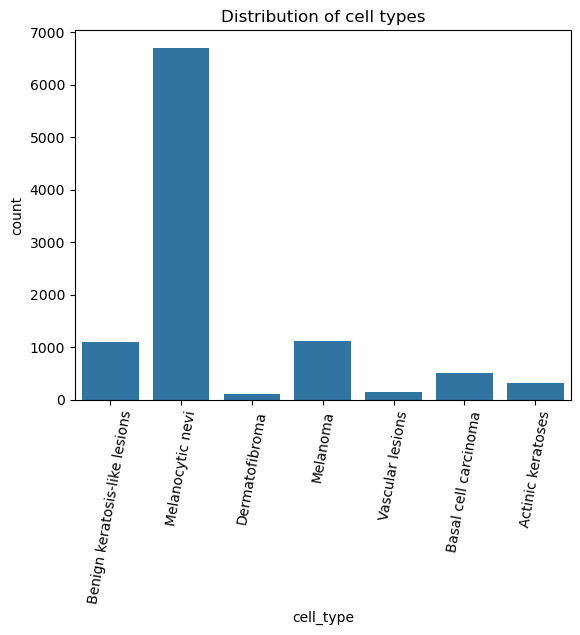

In [ ]:
chart = sns.countplot(x='cell_type', data=skin_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
chart.set_title('Distribution of cell types')

##### According to the plot, Melanocytic nevi is the most common type of skin cancer.

Text(0.5, 1.0, 'Distribution of diagnosis techniques (ground truth)')

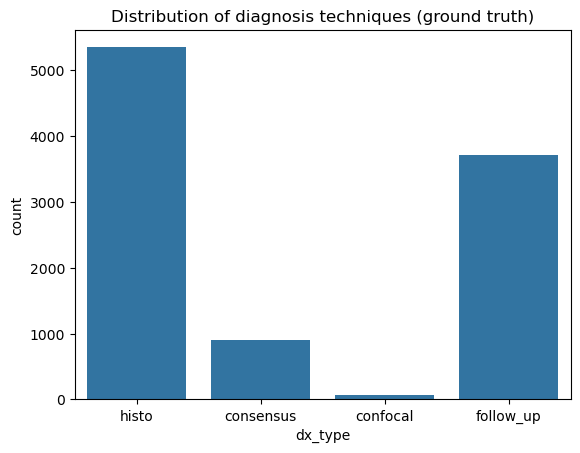

In [ ]:
sns.countplot(x='dx_type', data=skin_df).set_title('Distribution of diagnosis techniques (ground truth)')

##### In the above plot, the distribution of diagnosis techniques are illustrated. These techniques are as follows:
1. Histopathology(Histo): Histopathologic diagnosis od lesions performed by specialized dermatopathologists.
2. Follow-up: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
3. Consensus: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.
4. Confocal: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.

/tmp/ipykernel_2086302/289870349.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=60)


Text(0.5, 1.0, 'Distribution of skin cancer regions')

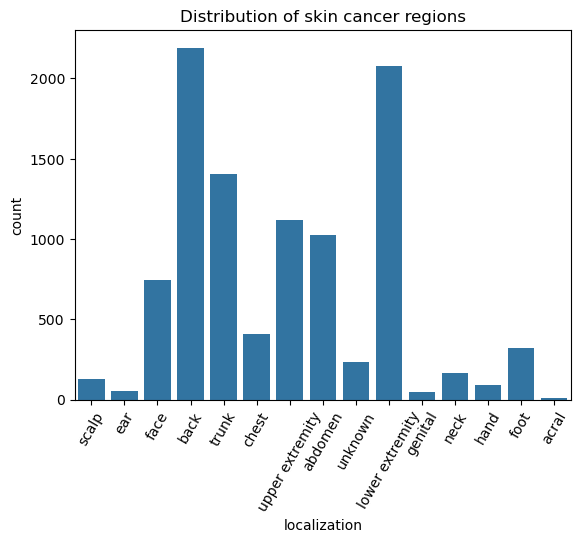

In [ ]:
chart = sns.countplot(x='localization', data=skin_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
chart.set_title('Distribution of skin cancer regions')

##### As we can see, lower extremity and back regions are the most common skin cancer locations.

Text(0.5, 1.0, 'Distribution of age')

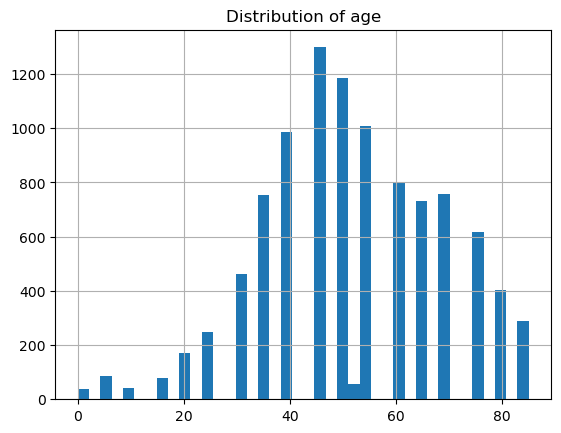

In [ ]:
plot = skin_df['age'].hist(bins=40)
plot.set_title('Distribution of age')

##### This plot shows that a large number of patients are between 30 to 60 years old.

Text(0.5, 1.0, 'Distribution of sex')

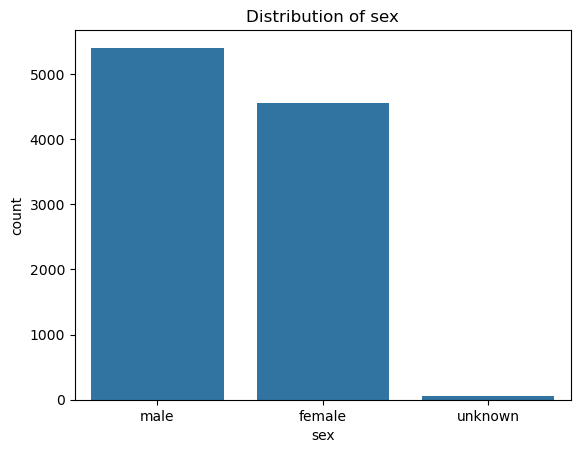

In [ ]:
sns.countplot(x='sex', data=skin_df).set_title('Distribution of sex')

Text(0.5, 1.0, 'Distribution of sex by cell types')

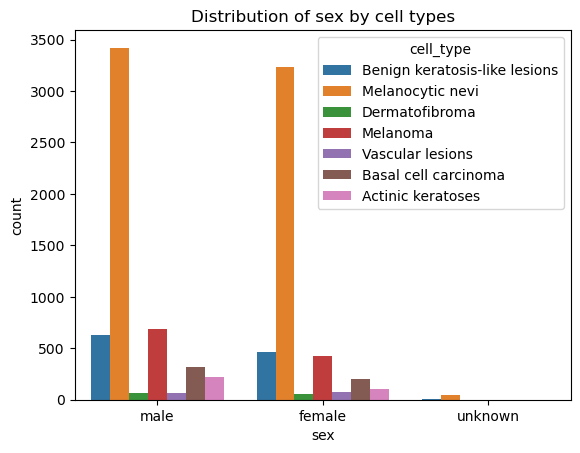

In [ ]:
sns.countplot(x='sex', hue='cell_type', data=skin_df).set_title('Distribution of sex by cell types')

### 3- Creating datasets

In [ ]:
class SkinLesionData(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

### 4- Transfer Learning

In [ ]:
# Defining a function to select whether we want to extract features or finetune the model.
# If feature_extract = False, the model is finetuned and all model parameters are updated.
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def param_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# Defining a function to select pretrained models
def model_selection(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = None
    input_size = 0

    if model_name == 'resnet':
       model_ft = models.resnet50(pretrained=use_pretrained)
       param_requires_grad(model_ft, feature_extract)
       num_ftrs = model_ft.fc.in_features
       model_ft.fc = nn.Linear(num_ftrs, num_classes)
       input_size = 224

    elif model_name == 'convnext_base':
         model_ft = models.convnext_base(weights='IMAGENET1K_V1')
         param_requires_grad(model_ft, feature_extract)
         num_ftrs = model_ft.classifier[2].in_features
         model_ft.classifier[2] = nn.Linear(num_ftrs, num_classes)
         input_size = 224

    elif model_name == "densenet":
         model_ft = models.densenet121(weights='IMAGENET1K_V1')
         param_requires_grad(model_ft, feature_extract)
         num_ftrs = model_ft.classifier.in_features
         model_ft.classifier = nn.Linear(num_ftrs, num_classes)
         input_size = 224

    else:
        print("Invalid Model Name")
        exit()
    return model_ft, input_size

### 5- Defining the pretrained model

In [ ]:
model_name = 'convnext_base'
num_classes = 7
feature_extract = True

# Initialize the model
model_ft, input_size = model_selection(model_name, num_classes, feature_extract, use_pretrained=True)

# Put the model into device
device = torch.device('cuda:0')
model_ft = model_ft.to(device)

### 6- Creating dataset

In [ ]:
# Defining the transformation of the train images

train_transforms = transforms.Compose([transforms.Resize((input_size,input_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [ ]:
train_dataset = SkinLesionData(skin_df, transform=train_transforms)

### 7- Model Training

In [ ]:
# Defining k-fold cross validation
k_folds = 5
batch_size = 10
num_epochs = 20
history = {'train_loss': [], 'train_acc':[]}
per_fold_result_training = {}
results = {}

kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f'Fold: {fold + 1}')
    print('_' * 10)

    # Define the dataloaders for current fold
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx))

    val_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    # initialize the model, optimizer, and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch} / {num_epochs -1}')
        print('_' * 10)

        train_loss = 0
        total_samples = 0
        total_corrects = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            model_ft.train()

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model_ft(data)
            loss = criterion(outputs, target)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, pred = torch.max(outputs, 1)

            total_samples += target.size(0)
            total_corrects += (pred == target).sum().item()
            train_acc = (total_corrects / total_samples) * 100

        print(f'Train loss:{(train_loss/len(train_loader)):.4f}, Train accuracy:{(train_acc):.2f}')

        history['train_loss'].append(train_loss/len(train_loader))
        history['train_acc'].append(train_acc)

        scheduler.step()

    per_fold_result_training['fold{}'.format(fold+1)] = history

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    PATH = f'./model-fold-{fold}.pth'
    torch.save(model_ft.state_dict(), PATH)

    total_val = 0
    val_loss = 0
    val_corrects = 0
    with torch.no_grad():
         for data, target in val_loader:
             model_ft.eval()

             data, target = data.to(device), target.to(device)

             output = model_ft(data)
             loss = criterion(output, target)

             total_val += target.size(0)
             val_loss += loss.item()

             _,pred = torch.max(output, 1)
             val_corrects += torch.sum(pred == target.data)

         # Print accuracy
         print('Accuracy for fold %d: %d %%' % (fold, 100.0 * val_corrects / total_val))
         print('--------------------------------')
         results[fold] = 100.0 * (val_corrects / total_val)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

Fold: 1
__________
Epoch: 0 / 19
__________
Train loss:0.6079, Train accuracy:78.16
Epoch: 1 / 19
__________
Train loss:0.5905, Train accuracy:78.82
Epoch: 2 / 19
__________
Train loss:0.5795, Train accuracy:78.94
Epoch: 3 / 19
__________
Train loss:0.5804, Train accuracy:78.71
Epoch: 4 / 19
__________
Train loss:0.5707, Train accuracy:79.19
Epoch: 5 / 19
__________
Train loss:0.5351, Train accuracy:80.32
Epoch: 6 / 19
__________
Train loss:0.5331, Train accuracy:80.55
Epoch: 7 / 19
__________
Train loss:0.5262, Train accuracy:80.62
Epoch: 8 / 19
__________
Train loss:0.5269, Train accuracy:80.28
Epoch: 9 / 19
__________
Train loss:0.5240, Train accuracy:80.77
Epoch: 10 / 19
__________
Train loss:0.5237, Train accuracy:80.72
Epoch: 11 / 19
__________
Train loss:0.5167, Train accuracy:81.05
Epoch: 12 / 19
__________
Train loss:0.5183, Train accuracy:81.14
Epoch: 13 / 19
__________
Train loss:0.5219, Train accuracy:80.89
Epoch: 14 / 19
__________
Train loss:0.5257, Train accuracy:80.52
E

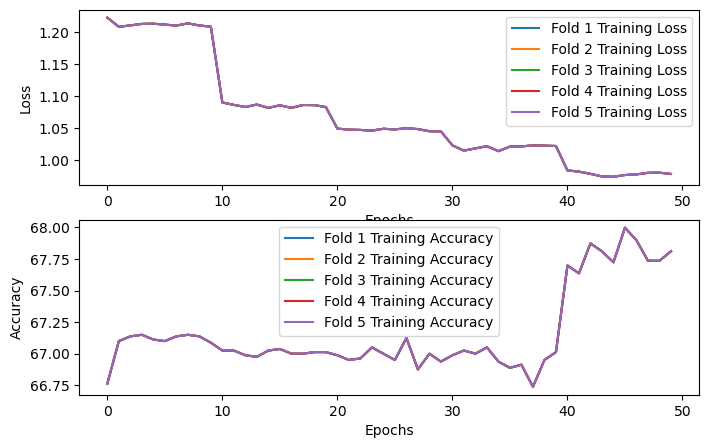

In [ ]:
plt.figure(figsize=(8,5))
plt.subplot(211)
plt.plot(per_fold_result_training['fold1']['train_loss'],label='Fold 1 Training Loss')
plt.plot(per_fold_result_training['fold2']['train_loss'],label='Fold 2 Training Loss')
plt.plot(per_fold_result_training['fold3']['train_loss'],label='Fold 3 Training Loss')
plt.plot(per_fold_result_training['fold4']['train_loss'],label='Fold 4 Training Loss')
plt.plot(per_fold_result_training['fold5']['train_loss'],label='Fold 5 Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(212)
plt.plot(per_fold_result_training['fold1']['train_acc'],label='Fold 1 Training Accuracy')
plt.plot(per_fold_result_training['fold2']['train_acc'],label='Fold 2 Training Accuracy')
plt.plot(per_fold_result_training['fold3']['train_acc'],label='Fold 3 Training Accuracy')
plt.plot(per_fold_result_training['fold4']['train_acc'],label='Fold 4 Training Accuracy')
plt.plot(per_fold_result_training['fold5']['train_acc'],label='Fold 5 Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()